### Slit Losses

Description : I need to take into account the missed Lya flux due to the size of the Binospec slits used.

Plan : 

1 - Creat model for Lya surface brightness. Based on Leclerq+17

2 - Distribution of Binospec slit sizes

3 - Convolve with Binospec PSF, each mask should have different PSF. (This should be somewhere done in my code)

4 - Calculate the fraction of Lya flux in the median binospec slit = f_captured

5 - Save results





In [1]:
import numpy as np
import glob as glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from LyaSurfaceBrightness import *
import SlitsObj
import scipy.integrate
from scipy.optimize import curve_fit

### 1 - Creat model for Lya surface brightness. Based on Leclerq+17

Halo of 3.8kpc

Core of 0.3kpc

Decreasing exponentials

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


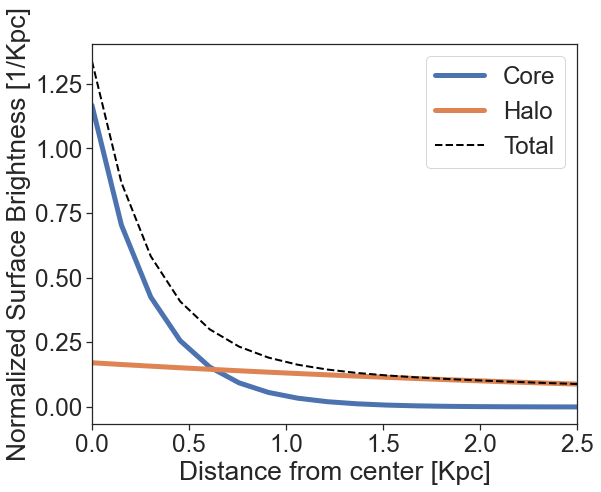

In [10]:

%load_ext autoreload
%autoreload 
plt.rcParams["figure.figsize"] = (8.7,7.)
sns.set_theme(style="ticks",font_scale=2.2)

distance_from_center,surface_brightness_core=surface_brightness_profile("core")
_,surface_brightness_halo=surface_brightness_profile("halo")
surface_brightnes=surface_brightness_core+surface_brightness_halo

plt.plot(distance_from_center,surface_brightness_core,lw=5,label="Core")
plt.plot(distance_from_center,surface_brightness_halo,lw=5,label="Halo")
plt.plot(distance_from_center,surface_brightnes,lw=2,label="Total",color="black",ls="--")
plt.xlabel("Distance from center [Kpc]")
plt.ylabel("Normalized Surface Brightness [1/Kpc]")
plt.xlim(0,2.5)
plt.legend()
plt.show()


### 2- Distribution of Binospec slit sizes

Load every 2D slit of an LAE and see the size of slit. 

Convert to arcseconds

Convert to Kpc, using redshift and cosmological method of distance

Give each galaxy a self.mask value, to know which mask it belongs to

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


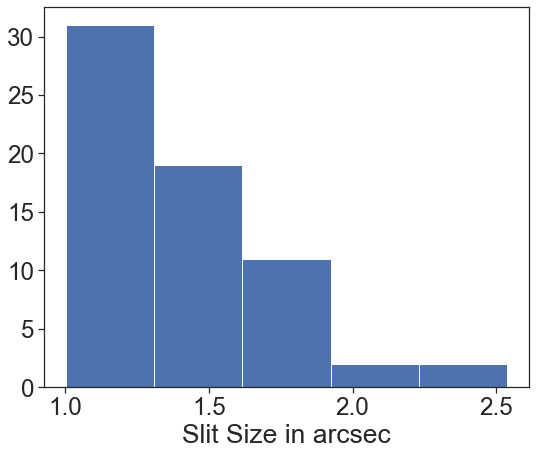

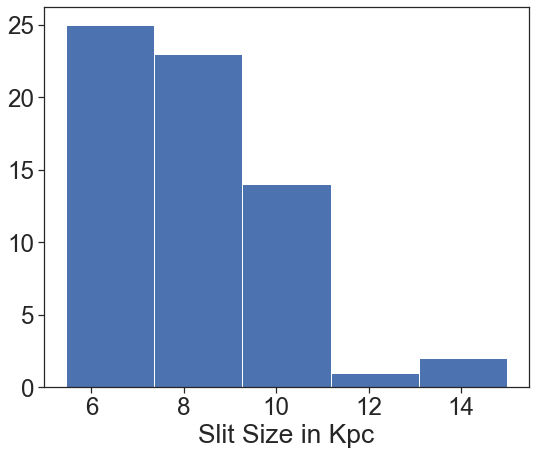

In [3]:
%load_ext autoreload
%autoreload 
Catalog=ascii.read("../../A-Catalogs/Binospec-Candels.cat")
Specs1=read_data("large_files/Reduced_Data/Mask1/2D/noiseCorrected/*.fits",Catalog,"1")
Specs2=read_data("large_files/Reduced_Data/Mask2_1/2D/noiseCorrected/*.fits",Catalog,"2")
Specs3=read_data("large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits",Catalog,"3")
Specs4=read_data("large_files/Reduced_Data/Mask2_3/2D/noiseCorrected/*.fits",Catalog,"4")
Specs4=np.delete(Specs4,4)
Specs=merged_array = np.concatenate((Specs1, Specs2, Specs3, Specs4))


[Obj.add_cat(Catalog) for Obj in Specs]
[Obj.slit_physical_size() for Obj in Specs]


slitsH=[]
for gal in Specs:
    slitsH.append(gal.slitHeight.value)
plt.hist(slitsH,bins=5)
plt.xlabel("Slit Size in arcsec")
plt.show()


size_slit=[]
for gal in Specs:
    size_slit.append(gal.slit_size_kpc.value)
plt.hist(size_slit,bins=5)
plt.xlabel("Slit Size in Kpc")
plt.show()

#Specs2=read_data("large_files/Reduced_Data/Mask2_1/2D/noiseCorrected/*.fits")
#Specs3=read_data("large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits")
#Specs4=read_data("large_files/Reduced_Data/Mask2_3/2D/noiseCorrected/*.fits")

### 5 - Calculate Seeing for PSF

1 - Im stupid and didnt save this

2 - Load the star files for each mask

3 - Grab a column of data around different parts of the Slit where there is no sky noise.

4 - Fit a Gaussian

5 - Obtain the FWHM, thats the seeing


In [4]:
f_mask1 = glob.glob("../../A-Catalogs/data/large_files/Reduced_Data/Mask1/2D/noiseCorrected/*f_*.fits")
f_mask2 = glob.glob("../../A-Catalogs/data/large_files/Reduced_Data/Mask2_1/2D/noiseCorrected/*f_*.fits")
f_mask3 = glob.glob("../../A-Catalogs/data/large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*f_*.fits")
f_mask4 = glob.glob("../../A-Catalogs/data/large_files/Reduced_Data/Mask2_3/2D/noiseCorrected/*f_*.fits")

%load_ext autoreload
%autoreload 

mask_psf={"1":obtain_psf_for_mask(f_mask1),"2":obtain_psf_for_mask(f_mask2),\
    "3":obtain_psf_for_mask(f_mask3),"4":obtain_psf_for_mask(f_mask4)}




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 4 - Convolve with Binospec PSF, each mask should have different PSF. (This should be somewhere done in my code)

1 - First I use my model from before and put it into a 2D array

2 - Then I generate the PSF, where it will be a gaussian with FWHM = the FWHM of the stars of the given mask

3 - Convolve with scipy convolve 2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


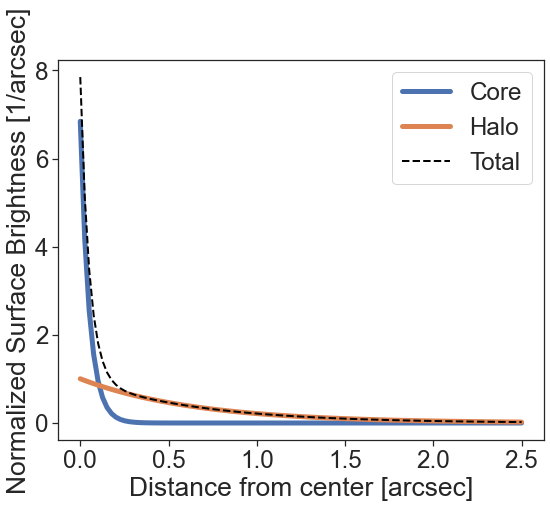

In [5]:
%load_ext autoreload
%autoreload 
plt.rcParams["figure.figsize"] = (8.7,7.)
sns.set_theme(style="ticks",font_scale=2.2)

distance_from_center,surface_brightness_core=surface_brightness_profile("core",unit="arcsec",obj=Specs[0])
_,surface_brightness_halo=surface_brightness_profile("halo",unit="arcsec",obj=Specs[0])
surface_brightnes=surface_brightness_core+surface_brightness_halo

plt.plot(distance_from_center,surface_brightness_core,lw=5,label="Core")
plt.plot(distance_from_center,surface_brightness_halo,lw=5,label="Halo")
plt.plot(distance_from_center,surface_brightnes,lw=2,label="Total",color="black",ls="--")
plt.xlabel("Distance from center [arcsec]")
plt.ylabel("Normalized Surface Brightness [1/arcsec]")
plt.legend()
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


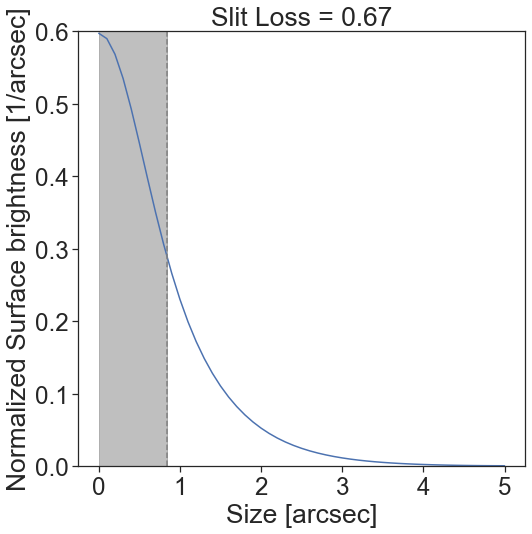

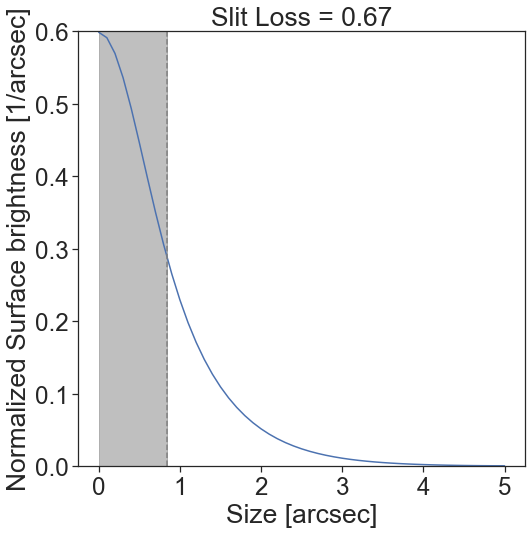

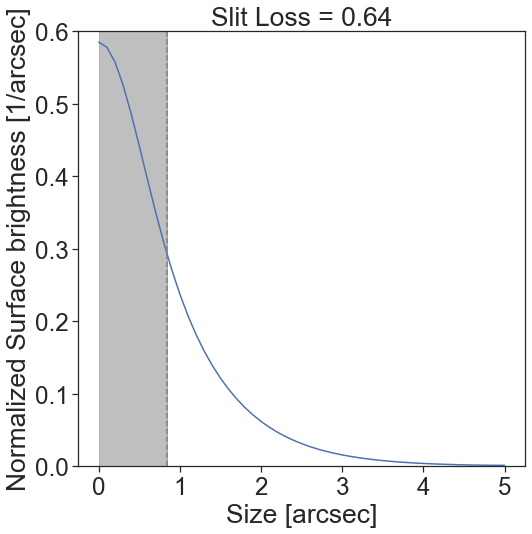

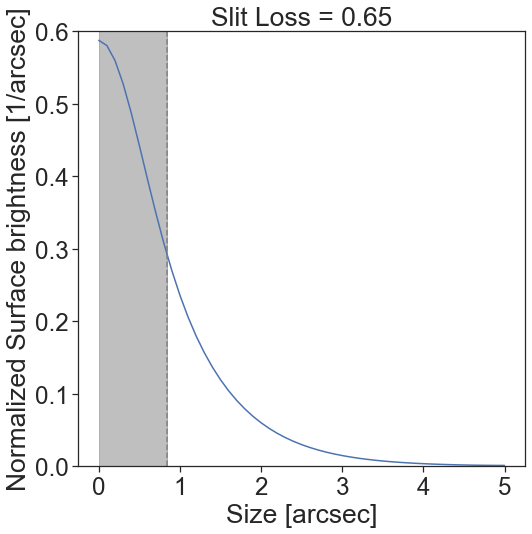

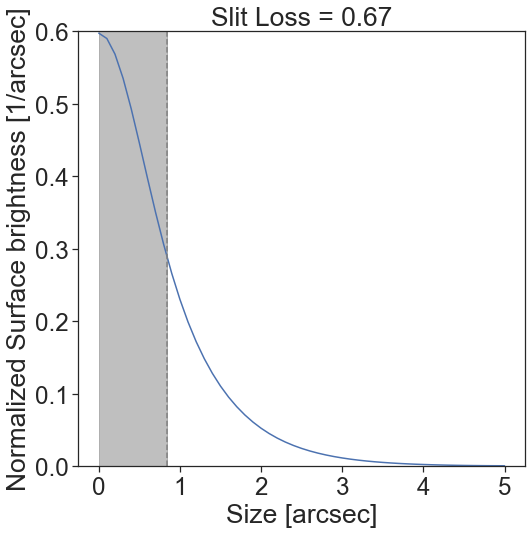

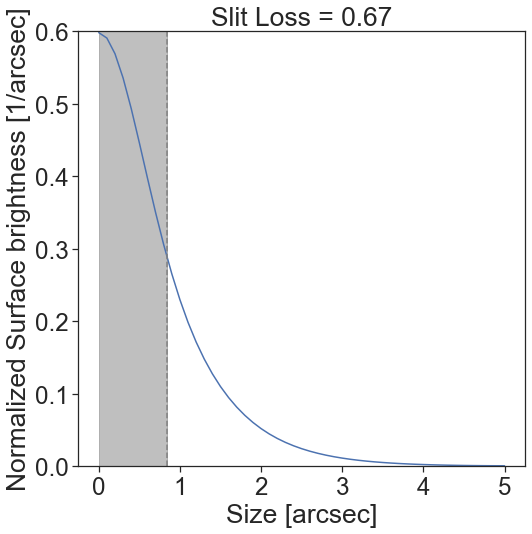

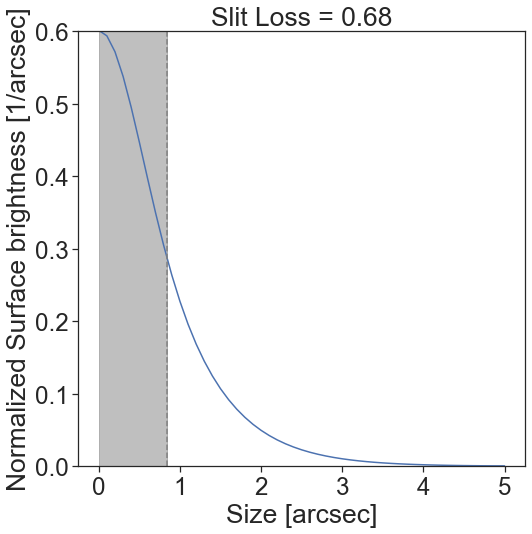

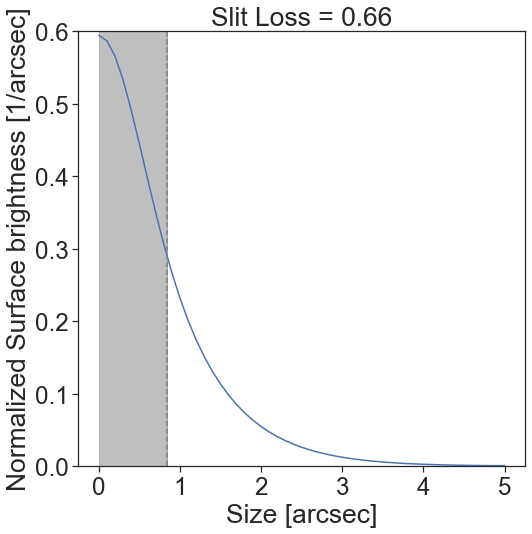

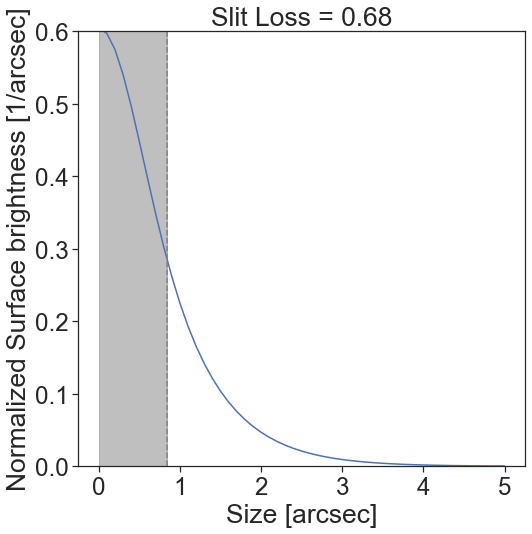

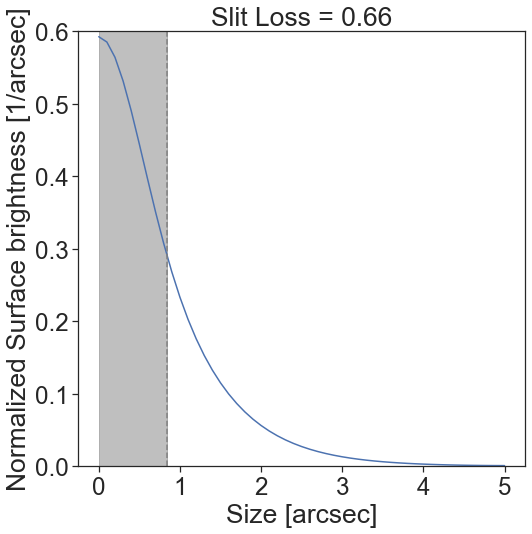

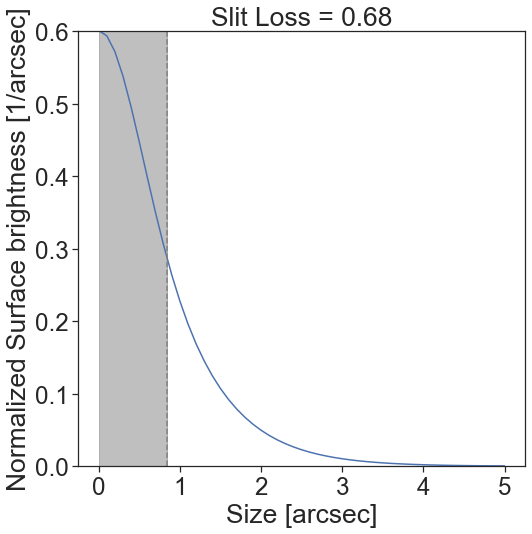

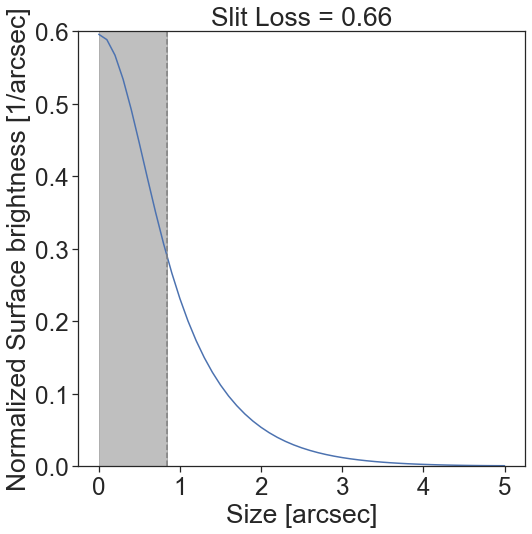

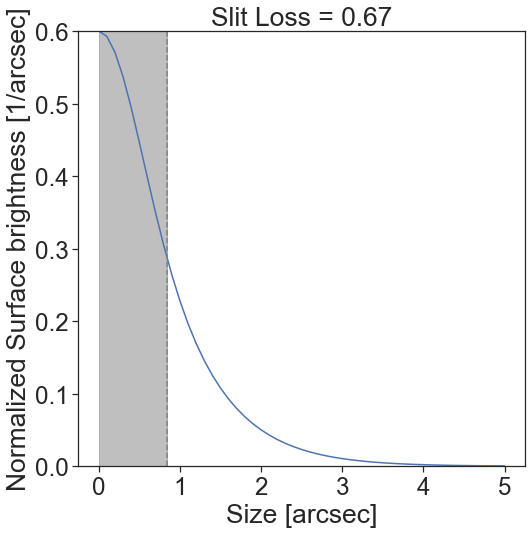

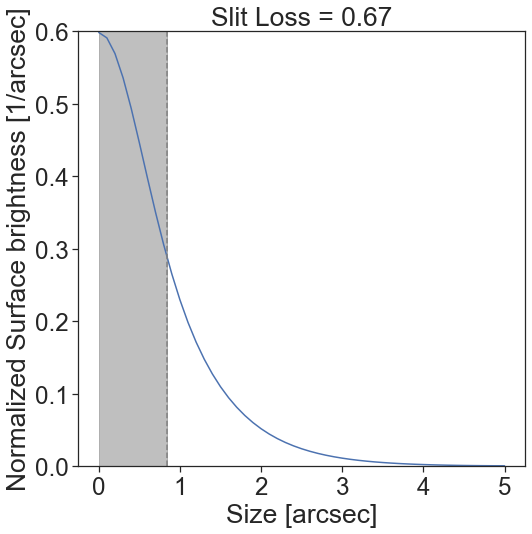

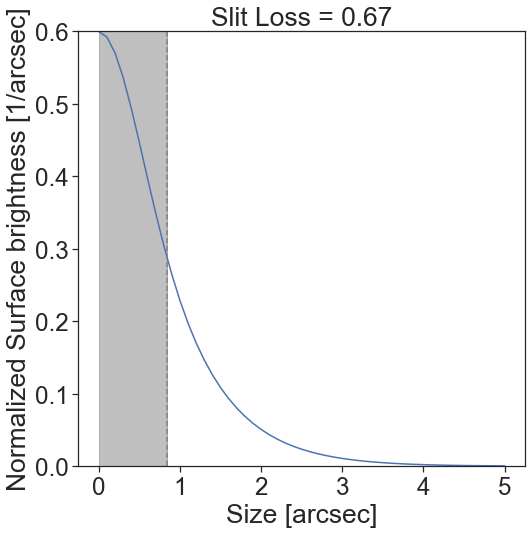

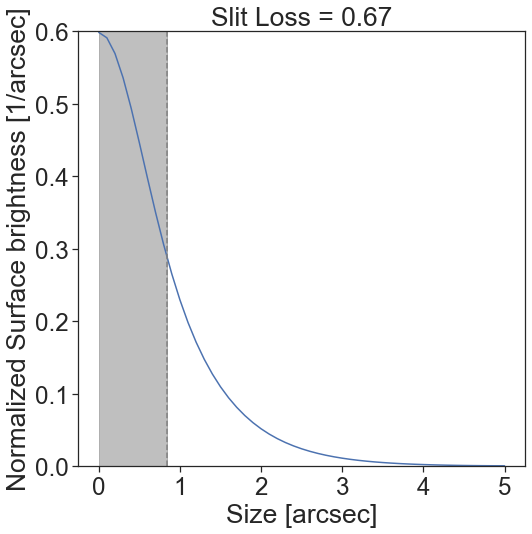

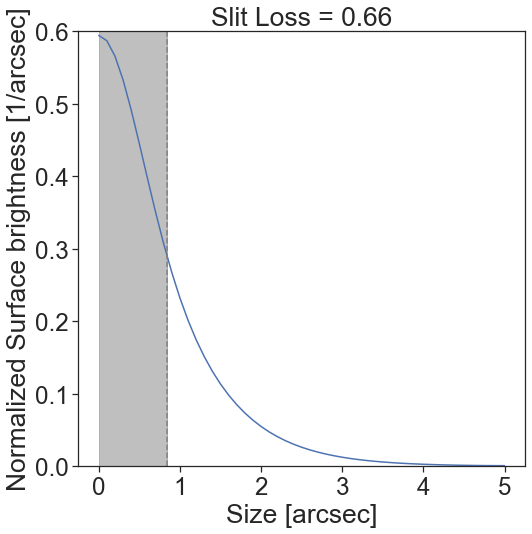

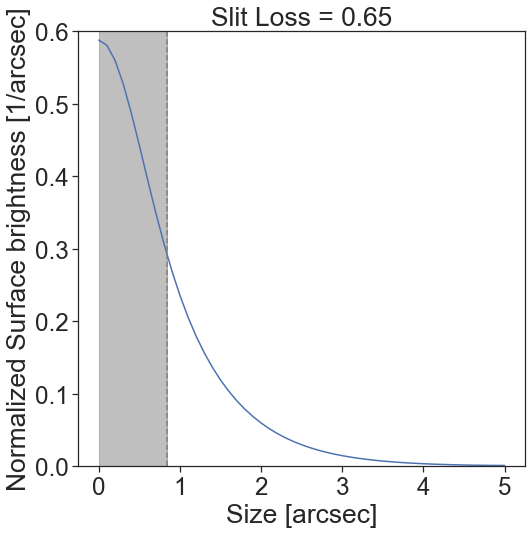

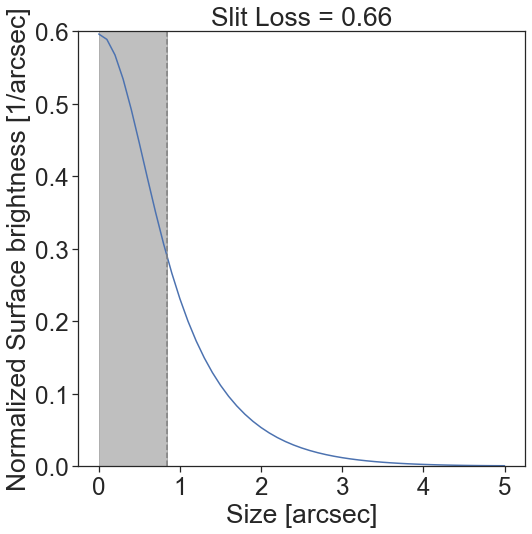

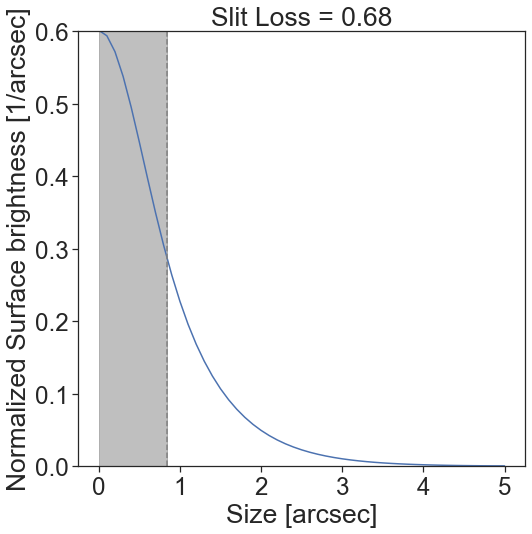

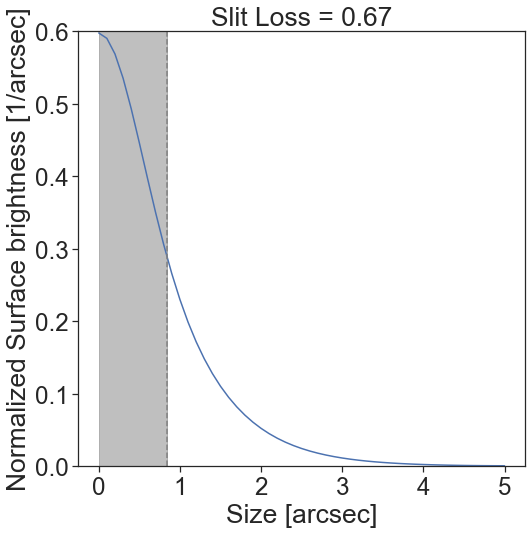

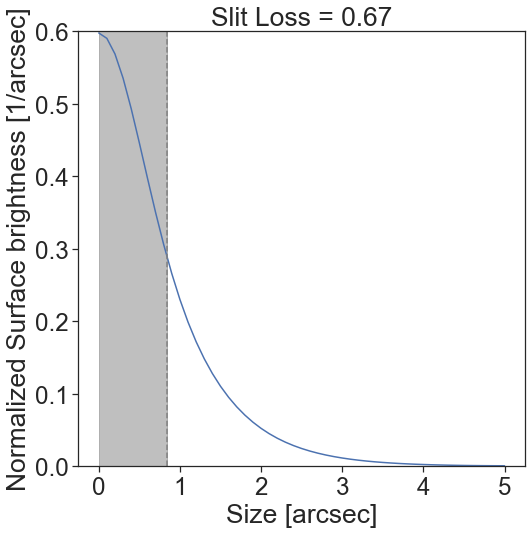

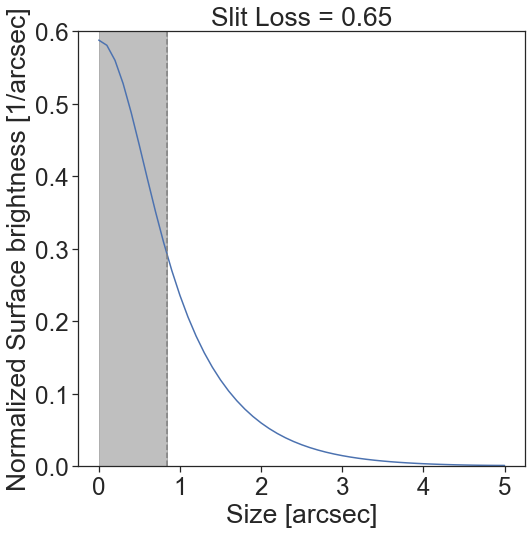

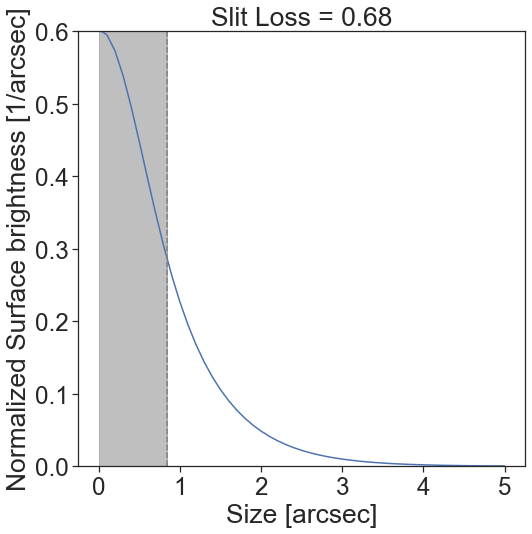

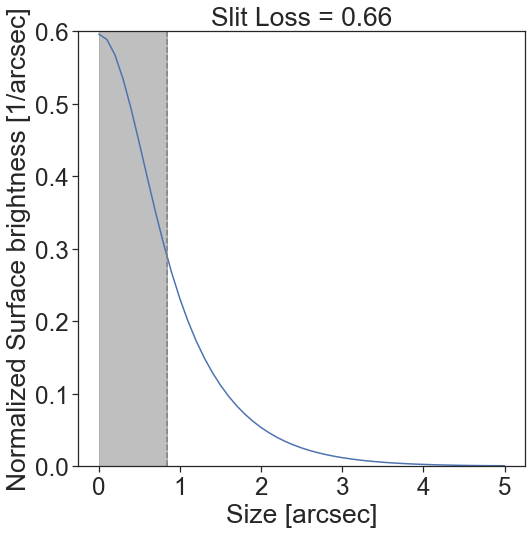

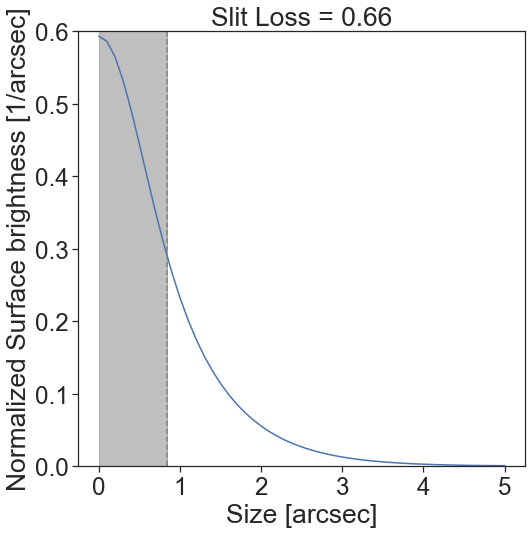

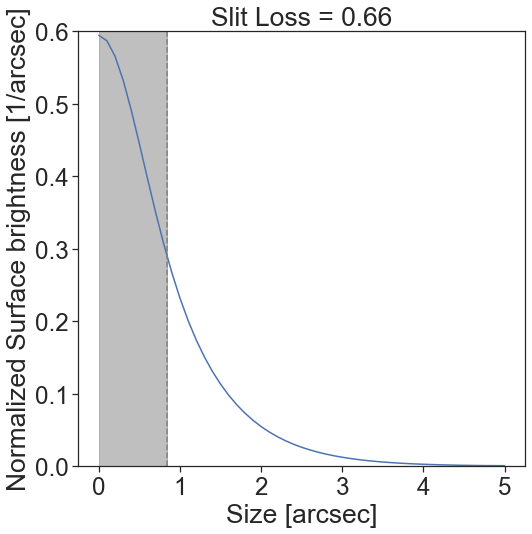

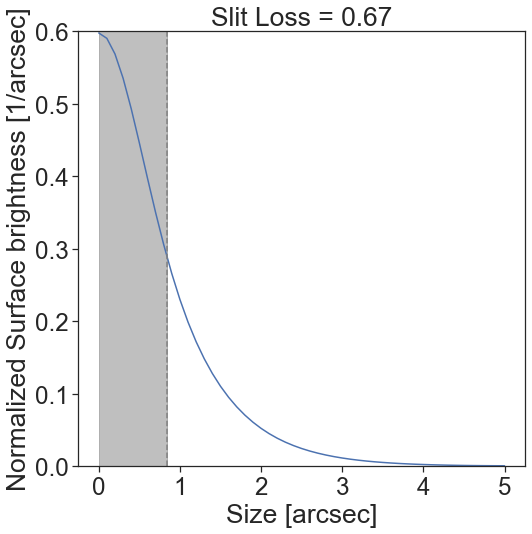

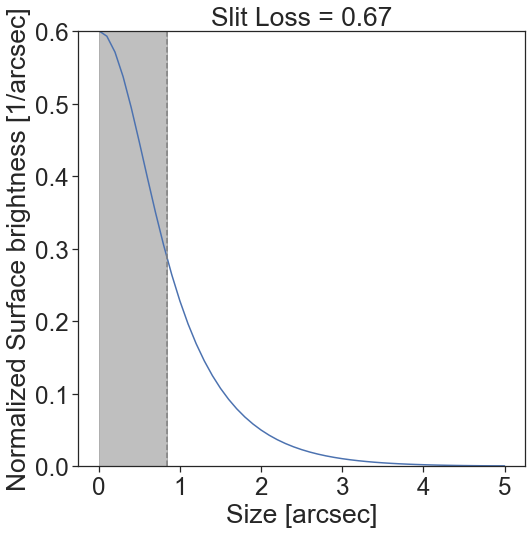

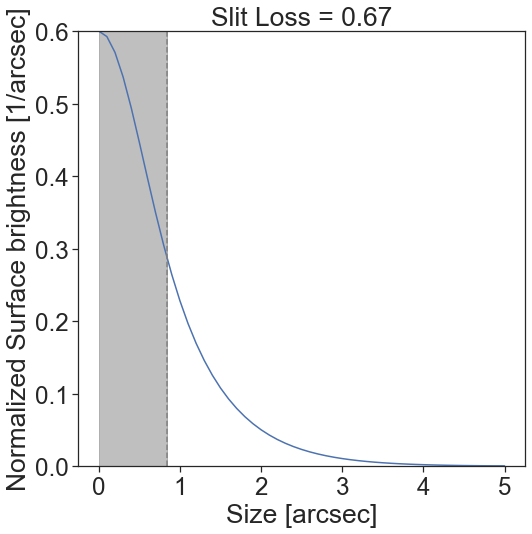

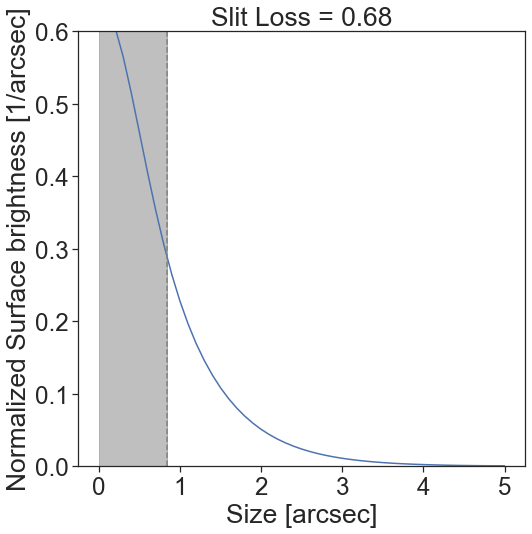

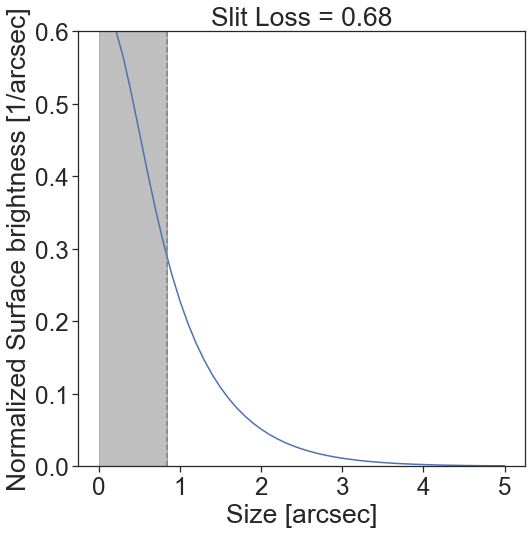

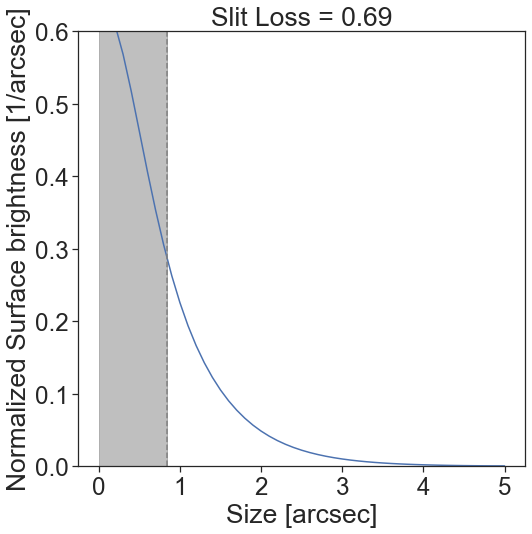

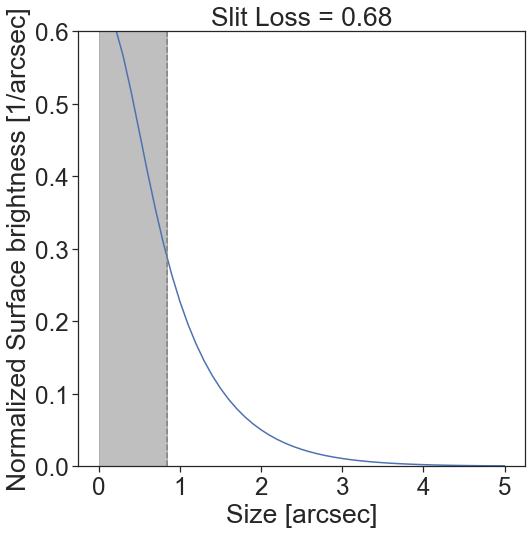

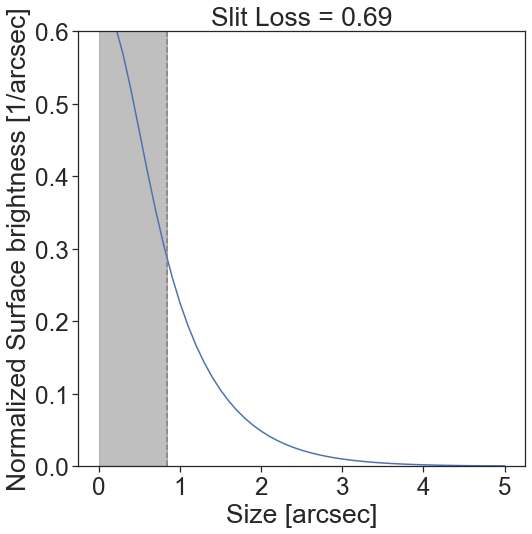

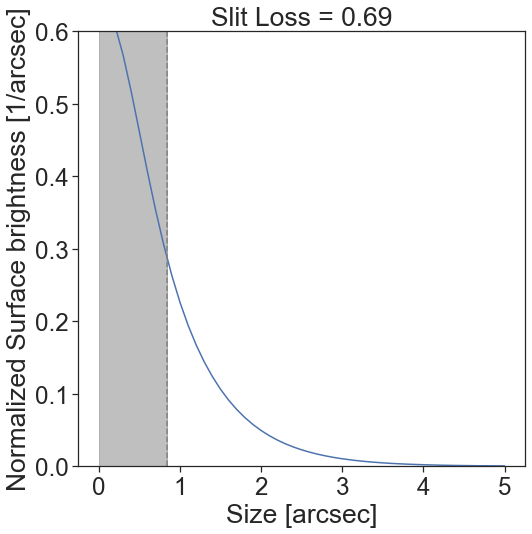

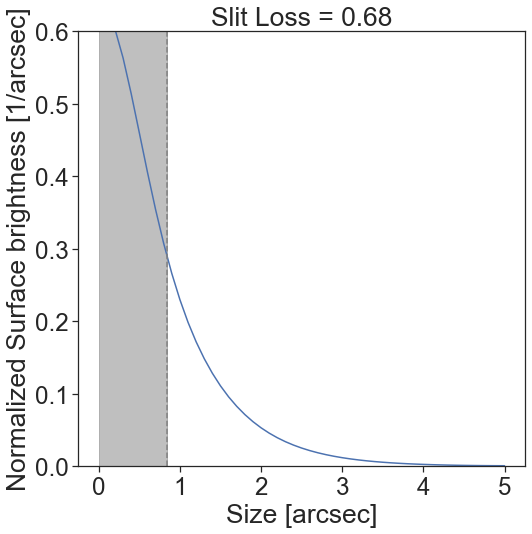

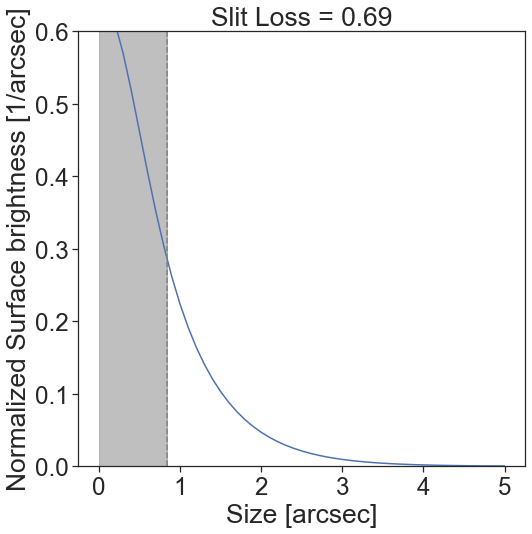

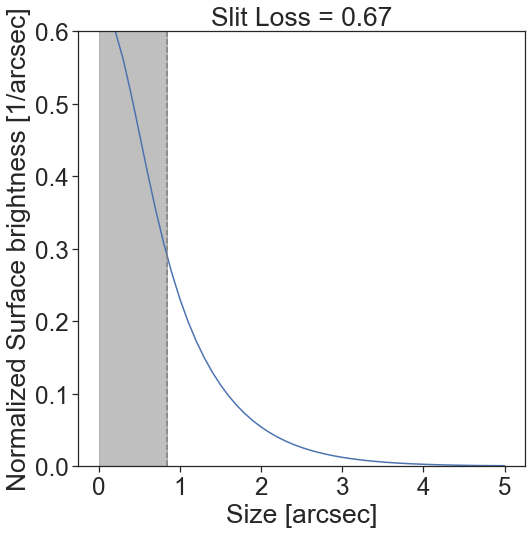

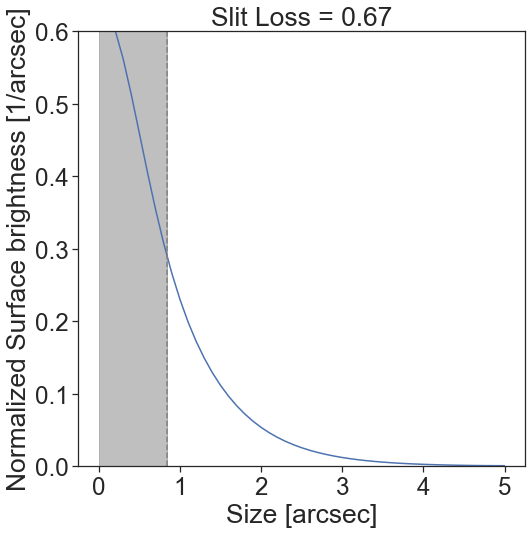

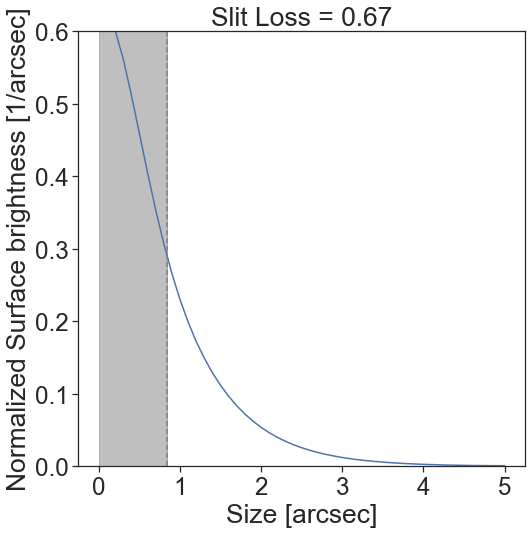

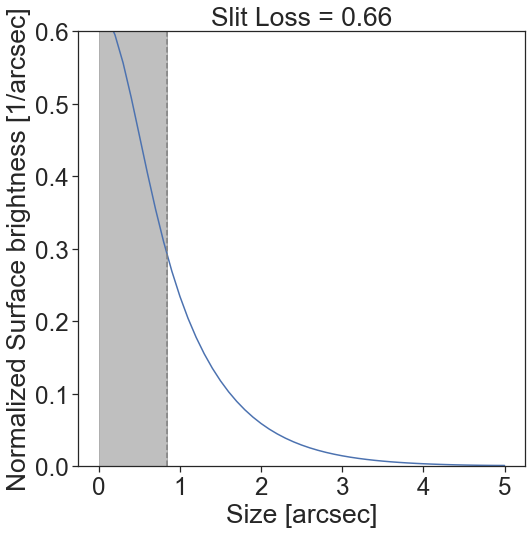

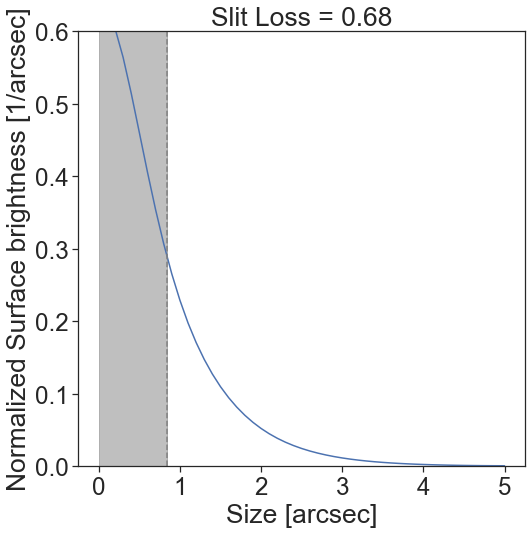

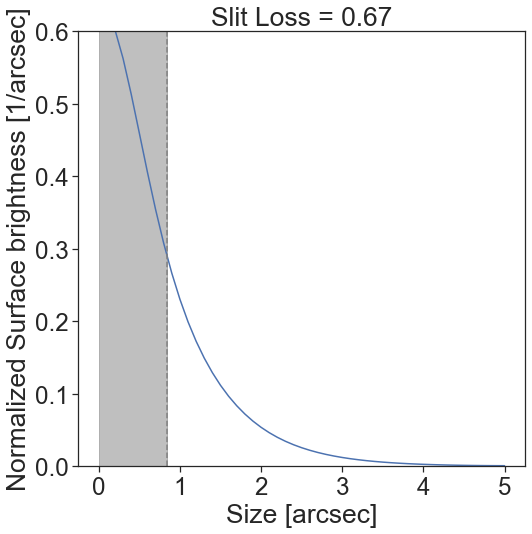

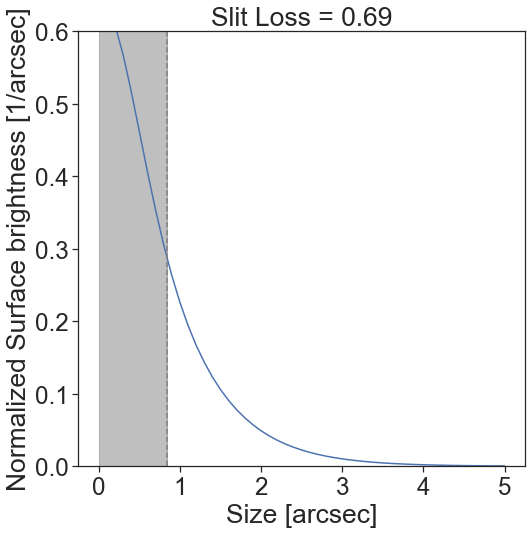

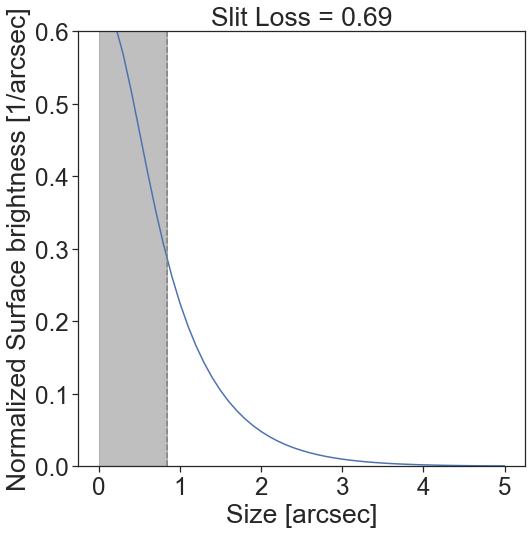

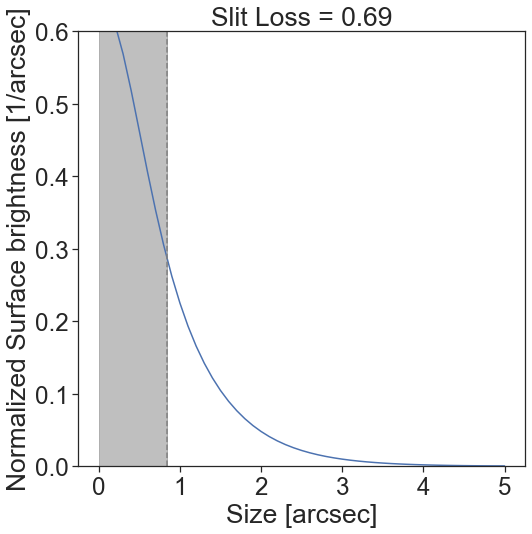

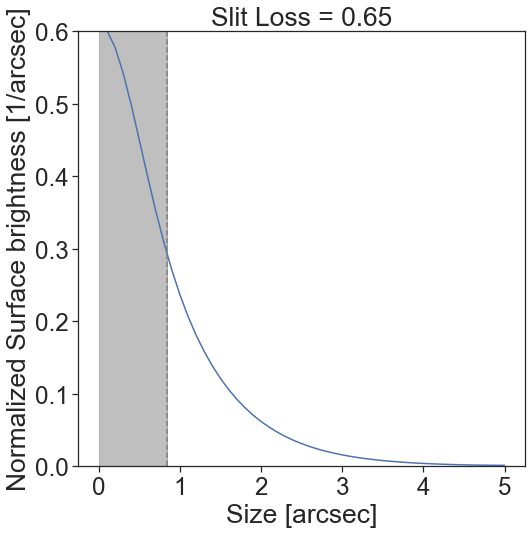

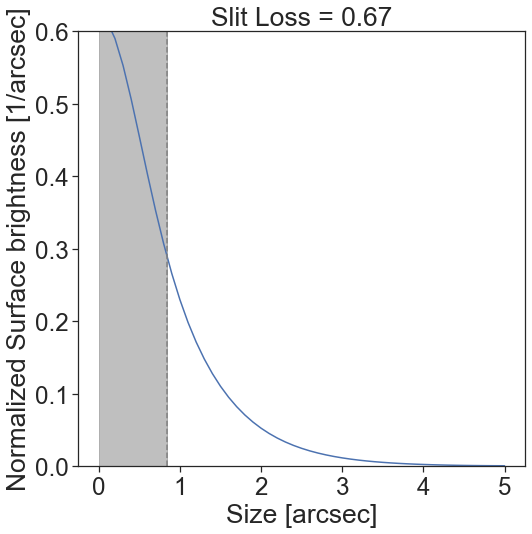

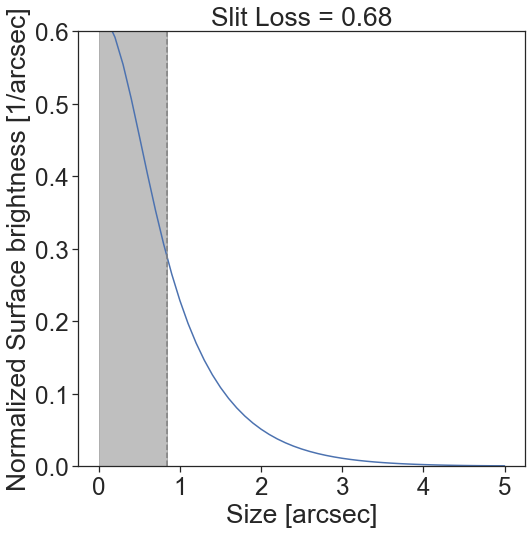

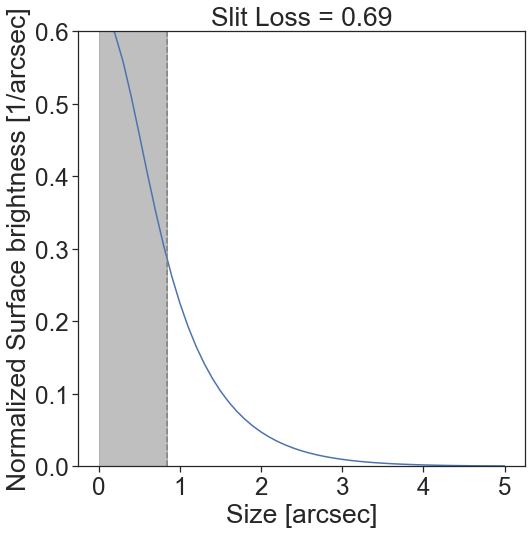

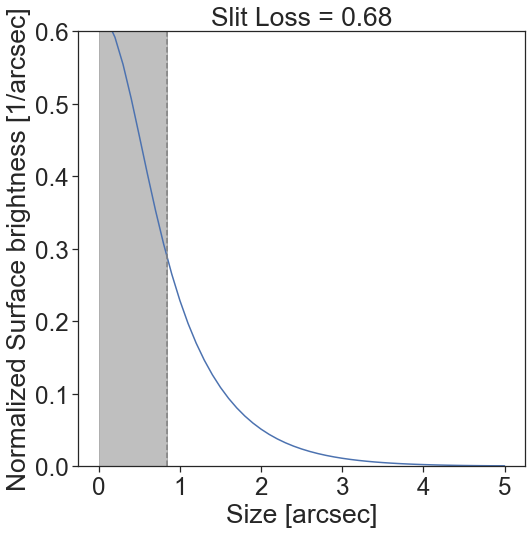

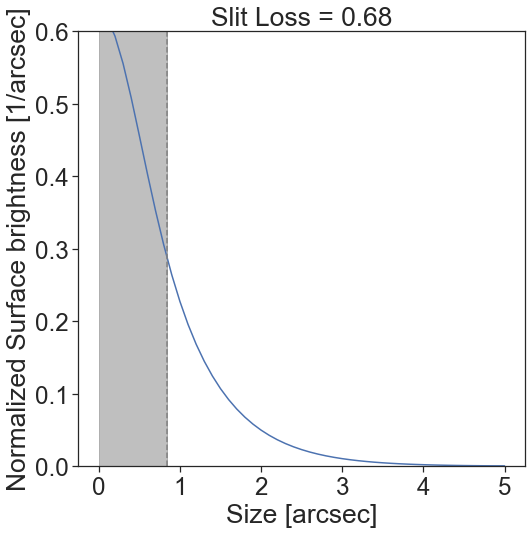

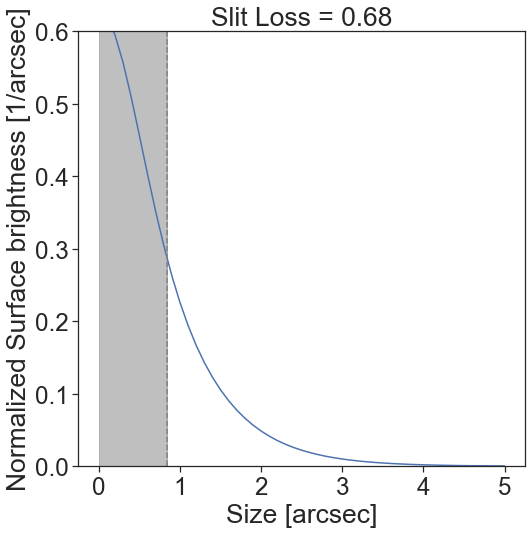

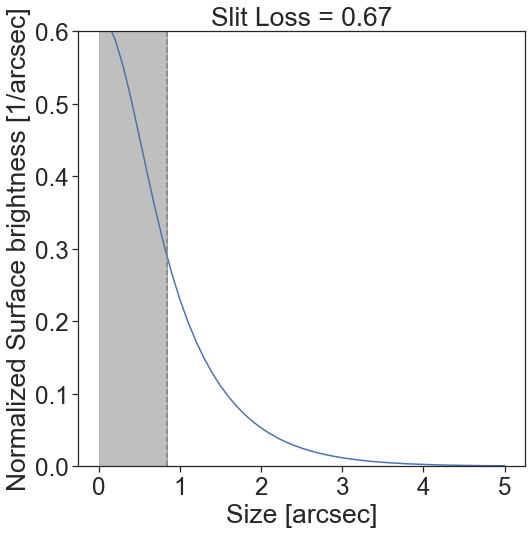

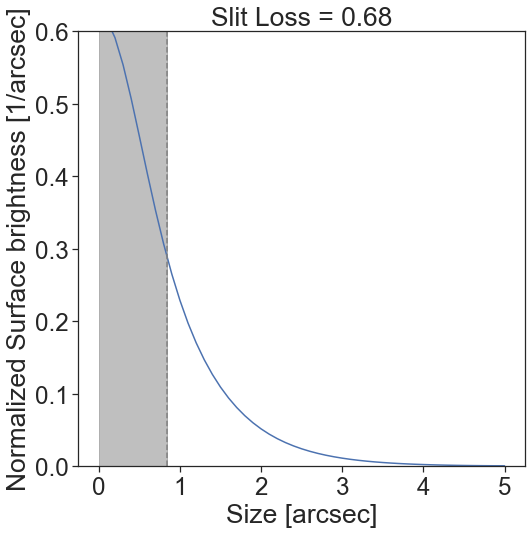

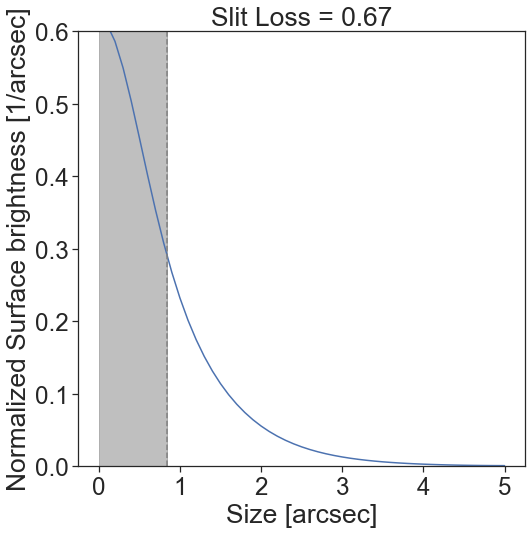

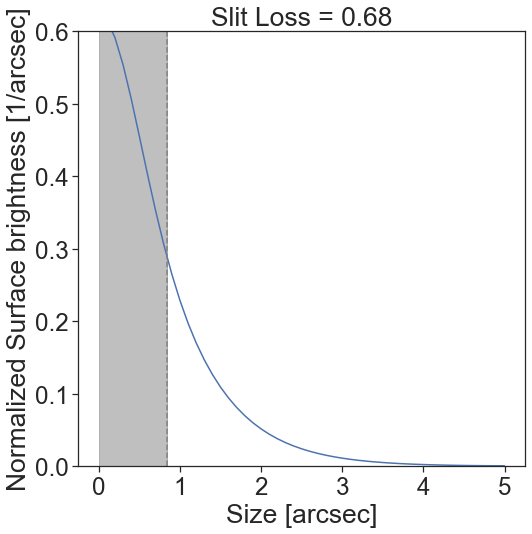

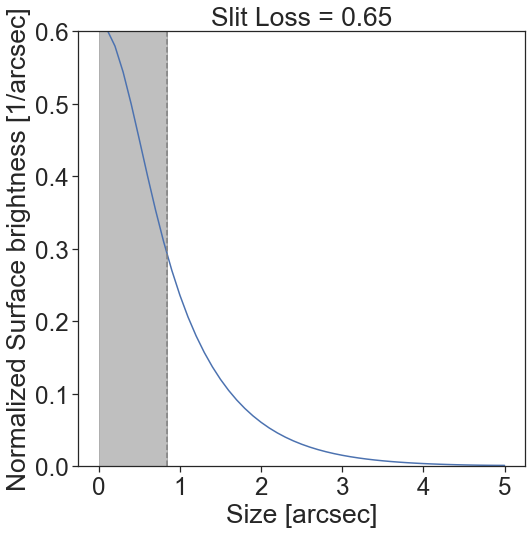

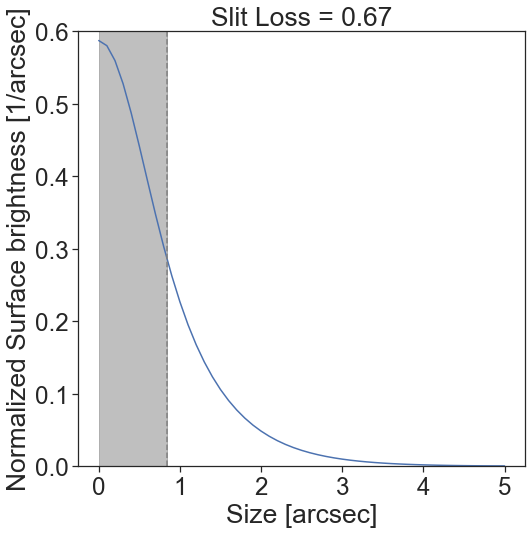

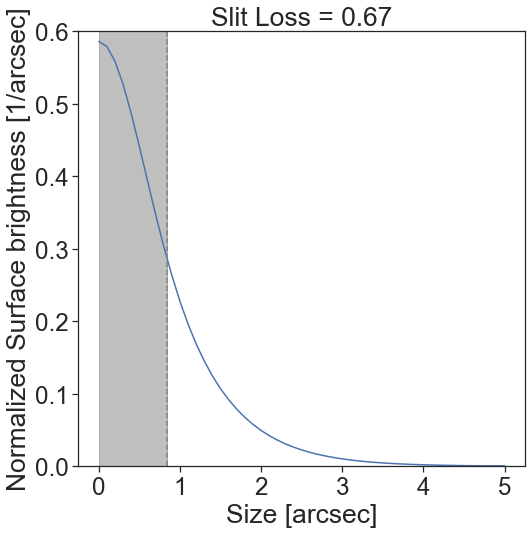

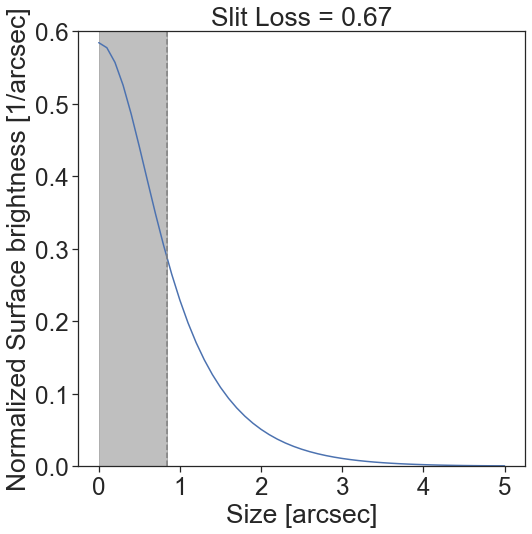

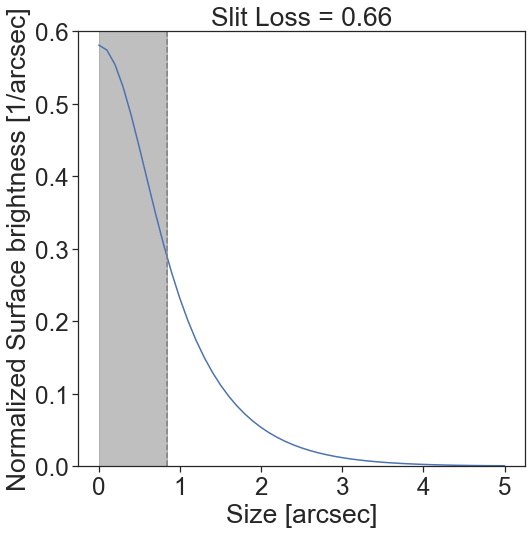

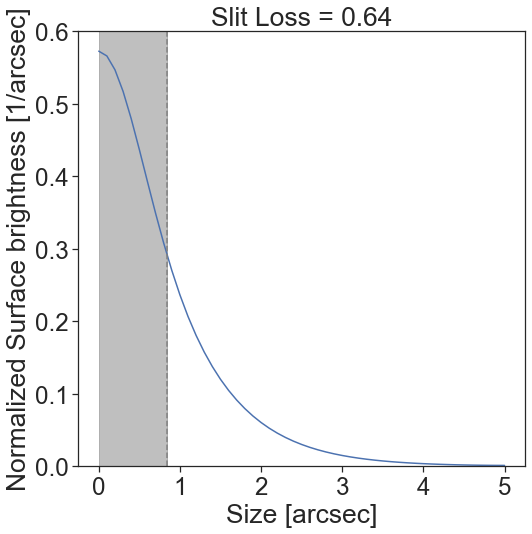

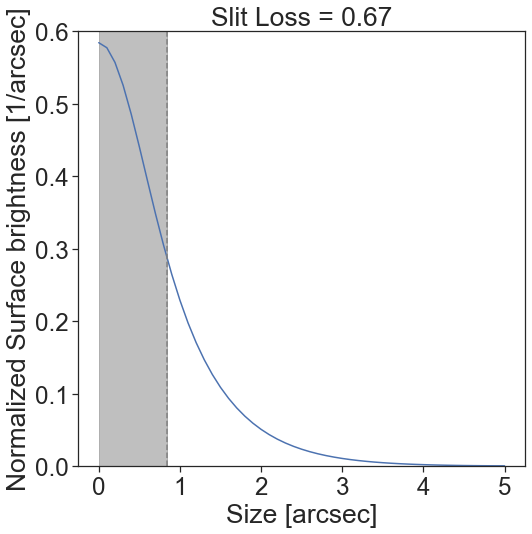

In [12]:
import numpy as np
from scipy.signal import convolve2d
from LyaSurfaceBrightness import *
%load_ext autoreload
%autoreload 
plt.rcParams["figure.figsize"] = (8,8.)
sns.set_theme(style="ticks",font_scale=2.2)
# Example usage


# Generate the 2D exponential array forming a circle around the center
slit_losses=[]
for Objeto in Specs[:]:

    Objeto.convolve_galaxy_with_psf(mask_psf,show_plot=False)
    Objeto.cut_galaxy_in_1d()
    Objeto.slit_loss_calculate(show_plot=True,extraction_size=7*0.24)
    slit_losses.append(Objeto.slit_loss)

Results={}
for Objeto in Specs:
    Results[list(Objeto.cat["id_charlotte"])[0]]=Objeto.slit_loss
np.save("../../A-Catalogs/slit_losses.npy",Results)

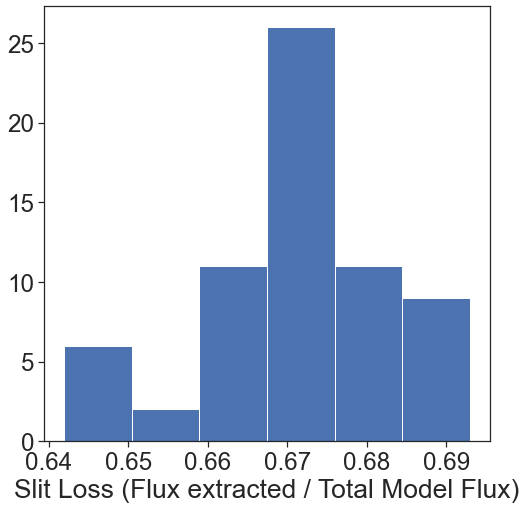

In [8]:
plt.hist(slit_losses,bins=6)
plt.xlabel("Slit Loss (Flux extracted / Total Model Flux)")
plt.show()     